In [328]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from scipy.fft import rfft, rfftfreq, irfft
from scipy.interpolate import interp1d
%matplotlib notebook

### Считывание данных

In [362]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
pd.set_option("max_info_columns", 500)
train_df

,data_1,data_2,data_3,data_4,data_5,data_6,data_7,data_8,data_9,data_10,...,data_292,data_293,data_294,data_295,data_296,data_297,data_298,data_299,data_300,label
0,-0.266033,-0.496437,-0.572447,-0.220903,0.266033,0.643705,0.365796,0.375297,0.014252,-0.527316,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,0.125475,-0.007605,-0.030418,0.285171,0.574144,0.418251,0.304183,0.277567,0.433460,0.231939,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,0.130435,0.445652,0.358696,0.086957,-0.076087,0.173913,0.173913,0.304348,0.141304,0.304348,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,0.032628,-0.019400,0.033510,-0.009700,0.037919,-0.014109,0.008818,-0.005291,0.027337,-0.037919,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,0.006105,0.005723,0.004197,-0.001145,-0.009538,-0.009538,-0.000382,-0.006868,-0.006105,-0.012591,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3787,-0.237154,0.035573,0.379447,0.579051,0.370553,-0.127470,-0.508893,-0.584980,-0.382411,-0.128458,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3788,-0.005171,-0.010341,-0.010686,-0.009997,-0.004826,0.009307,0.008618,-0.030679,-0.021372,-0.038263,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3789,-0.026871,-0.024952,0.030710,-0.057582,0.074856,0.107486,-0.003839,0.151631,0.142035,0.024952,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3790,0.094170,0.125561,0.269058,0.130045,-0.219731,0.134529,0.304933,0.251121,0.269058,0.139013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


### Разложение в ряд Фурье и предобработка данных 

Разложим в ряд, интерполируем, нормируем

In [343]:
def fft_for_data(data):
    '''
    Разложение в ряд Фурье с умножением на функцию Кайзера
    Частота дискретизации 117.2 кГц
    '''
    point_number=len(data)
    B = np.kaiser(point_number, 20)
    data = np.multiply(data, B)
    ampl = abs(rfft(data))
    freq = rfftfreq(point_number, 1/117.2)

    return [freq, ampl]


x = np.array([i for i in np.arange(0, 57, 0.1)]) # Границы частотной области, для интерполяции
data = []
fft_data = []

for i in range(0, len(train_df.values)):
    y = train_df.iloc[i]
    inf = y[-1]
    y = y[~np.isnan(y)][:-1].values
    x_freq, y_fft = fft_for_data(y)
    
    f = interp1d(x_freq, y_fft)
    y_fft = f(x)
    fft_data.append(y_fft/max(y_fft))
    data.append(y)

Отбор статистических параметров фурье-образов

In [331]:
def hf_pow(data):
    '''
    Мощность шума высокочастотной области
    '''
    return sum(data[x>=20])


def lf_pow(data):
    '''
    Мощность шума низкочастотной области
    '''
    return sum(data[x<20])

hfp = [hf_pow(np.array(res)) for res in fft_data]
lfp = [lf_pow(np.array(res)) for res in fft_data]

Урезаем низкочастотную область

<IPython.core.display.Javascript object>


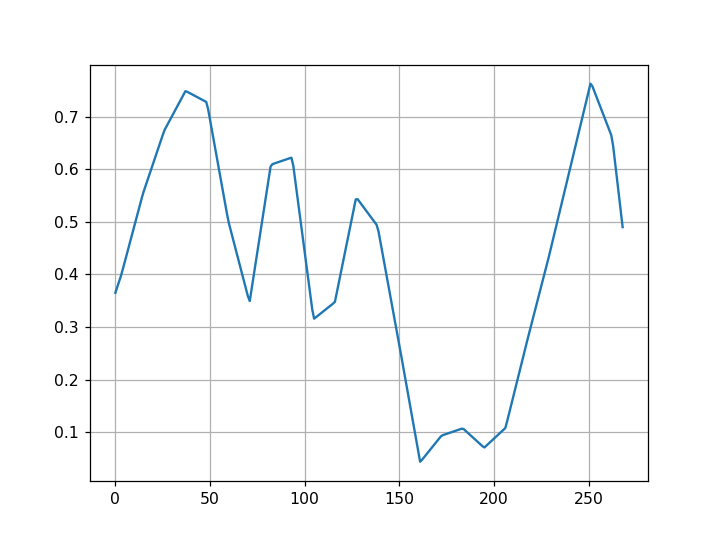

In [344]:
fft_data = np.array(fft_data)
fft_data_row = np.array([i[np.where(x > 30)] for i in fft_data])
df_fft_data = pd.DataFrame(fft_data_row)

fig, ax = plt.subplots()

ax.plot(df_fft_data.iloc[0])
ax.grid()

Отбор статистических параметров сигнала во временной области

In [729]:
import librosa
from scipy.interpolate import interp1d

cent, rolloff, zrate, mfccs, chromagram = ([] for i in range(5))
sr = 117000 # Гц


for i in range(0, len(train_df.values)):
    y = train_df.iloc[i]
    inf = y[-1]
    y = y[~np.isnan(y)][:-1].values
    
    signal_points = [i for i in np.arange(0, len(y)-1, len(y)/8192)]
    f = interp1d([i for i in range(len(y))], y)
    y = f(signal_points)
    
    y_harmonic, y_percussive = librosa.effects.hpss(y)

    cent.append(librosa.feature.spectral_centroid(y=y, sr=sr)[0, 0])
    rolloff.append(librosa.feature.spectral_rolloff(y=y, sr=sr)[0, 0])
    zrate.append(librosa.feature.zero_crossing_rate(y_harmonic)[0, 0])
    mfccs.append(librosa.feature.mfcc(y=y, sr=sr))
    chromagram.append(librosa.feature.chroma_stft(y=y, sr=sr))

c:\python\lib\site-packages\librosa\core\pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


### Извлечение фич

In [333]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings

In [334]:
settings_minimal = settings.MinimalFCParameters()
settings_time = settings.TimeBasedFCParameters()
settings_time.update(settings_minimal)
settings_efficient = settings.EfficientFCParameters()
settings_efficient.update(settings_time)

train данные

In [335]:
data_long = pd.DataFrame({0: df_fft_data.values.flatten(),
                          1: np.arange(df_fft_data.shape[0]).repeat(df_fft_data.shape[1])}).dropna()

X = extract_features(data_long, column_id=1, impute_function=impute, default_fc_parameters=settings_efficient)
X

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 10/10 [04:03<00:00, 24.32s/it]


,0__variance_larger_than_standard_deviation,0__has_duplicate_max,0__has_duplicate_min,0__has_duplicate,0__sum_values,0__abs_energy,0__mean_abs_change,0__mean_change,0__mean_second_derivative_central,0__median,...,0__fourier_entropy__bins_5,0__fourier_entropy__bins_10,0__fourier_entropy__bins_100,0__permutation_entropy__dimension_3__tau_1,0__permutation_entropy__dimension_4__tau_1,0__permutation_entropy__dimension_5__tau_1,0__permutation_entropy__dimension_6__tau_1,0__permutation_entropy__dimension_7__tau_1,0__query_similarity_count__query_None__threshold_0.0,0__mean_n_absolute_max__number_of_maxima_7
0,0.0,0.0,0.0,0.0,10.487591,0.599830,0.001429,-0.000134,-1.562129e-05,0.033096,...,0.170467,0.226363,0.316475,0.856821,1.050392,1.250639,1.457527,1.669018,0.0,0.112074
1,0.0,0.0,0.0,0.0,7.217383,0.290812,0.001420,-0.000045,-8.313185e-07,0.019980,...,0.090729,0.254093,0.519138,1.010092,1.369764,1.754153,2.126977,2.504935,0.0,0.091105
2,0.0,0.0,0.0,0.0,34.132122,5.290666,0.002968,0.000239,5.924091e-06,0.140555,...,0.204871,0.271451,0.316475,0.903759,1.146236,1.393151,1.649656,1.905149,0.0,0.230077
3,0.0,0.0,0.0,0.0,76.651058,41.039705,0.009207,0.002341,-4.465891e-05,0.199058,...,0.125256,0.125256,0.271451,0.865157,1.061973,1.249211,1.436274,1.623089,0.0,0.996526
4,0.0,0.0,0.0,0.0,7.702255,0.702703,0.002465,-0.000601,1.434223e-05,0.009722,...,0.090729,0.090729,0.374092,0.991664,1.337383,1.707585,2.077716,2.448512,0.0,0.158046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3787,0.0,0.0,0.0,0.0,13.100815,0.955949,0.001393,-0.000083,-4.306533e-06,0.037971,...,0.136002,0.181214,0.271451,0.861109,1.041532,1.234245,1.432091,1.629786,0.0,0.137274
3788,0.0,0.0,0.0,0.0,109.843560,52.529190,0.011168,0.000958,-4.012089e-05,0.383944,...,0.090729,0.170467,0.395585,0.888689,1.100063,1.325215,1.554968,1.789243,0.0,0.753659
3789,0.0,0.0,0.0,0.0,87.985672,36.173197,0.010229,-0.000828,-4.584519e-05,0.318932,...,0.190068,0.249958,0.470381,0.916868,1.159036,1.421548,1.693242,1.963452,0.0,0.820291
3790,0.0,0.0,0.0,0.0,73.331453,30.086298,0.008222,0.000974,-2.227762e-05,0.196719,...,0.136002,0.215617,0.363346,0.849710,1.036803,1.223760,1.415761,1.607515,0.0,0.690767


test данные

In [345]:
data_long_test = pd.DataFrame({0: df_fft_data.values.flatten(),
                          1: np.arange(df_fft_data.shape[0]).repeat(df_fft_data.shape[1])}).dropna()

X_test = extract_features(data_long_test, column_id=1, impute_function=impute, default_fc_parameters=settings_efficient)
X_test = X_test.drop(columns=to_drop)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.75s/it]


Исключение коррелируемых фич

In [336]:
cor_matrix = X.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.7)]
X_after_drop = X.drop(columns=to_drop)
X_after_drop

C:\Users\rafil\AppData\Local\Temp/ipykernel_18940/167237839.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))


,0__variance_larger_than_standard_deviation,0__has_duplicate_max,0__has_duplicate_min,0__has_duplicate,0__sum_values,0__mean_change,0__mean_second_derivative_central,0__length,0__variation_coefficient,0__longest_strike_below_mean,...,0__energy_ratio_by_chunks__num_segments_10__segment_focus_6,0__energy_ratio_by_chunks__num_segments_10__segment_focus_7,0__energy_ratio_by_chunks__num_segments_10__segment_focus_8,0__ratio_beyond_r_sigma__r_1.5,0__ratio_beyond_r_sigma__r_6,0__ratio_beyond_r_sigma__r_10,0__count_above__t_0,0__count_below__t_0,0__fourier_entropy__bins_2,0__query_similarity_count__query_None__threshold_0.0
0,0.0,0.0,0.0,0.0,10.487591,-0.000134,-1.562129e-05,269.0,0.683372,112.0,...,0.019742,0.009849,0.002984,0.066914,0.0,0.0,1.0,0.0,0.079983,0.0
1,0.0,0.0,0.0,0.0,7.217383,-0.000045,-8.313185e-07,269.0,0.708360,135.0,...,0.016040,0.013850,0.016187,0.078067,0.0,0.0,1.0,0.0,0.045395,0.0
2,0.0,0.0,0.0,0.0,34.132122,0.000239,5.924091e-06,269.0,0.470765,84.0,...,0.063670,0.178842,0.146167,0.159851,0.0,0.0,1.0,0.0,0.079983,0.0
3,0.0,0.0,0.0,0.0,76.651058,0.002341,-4.465891e-05,269.0,0.937535,177.0,...,0.001169,0.021913,0.099951,0.100372,0.0,0.0,1.0,0.0,0.079983,0.0
4,0.0,0.0,0.0,0.0,7.702255,-0.000601,1.434223e-05,269.0,1.478619,212.0,...,0.002450,0.002846,0.004366,0.126394,0.0,0.0,1.0,0.0,0.079983,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3787,0.0,0.0,0.0,0.0,13.100815,-0.000083,-4.306533e-06,269.0,0.705883,156.0,...,0.007797,0.009091,0.020676,0.133829,0.0,0.0,1.0,0.0,0.045395,0.0
3788,0.0,0.0,0.0,0.0,109.843560,0.000958,-4.012089e-05,269.0,0.413674,112.0,...,0.029472,0.024494,0.042698,0.144981,0.0,0.0,1.0,0.0,0.079983,0.0
3789,0.0,0.0,0.0,0.0,87.985672,-0.000828,-4.584519e-05,269.0,0.506895,91.0,...,0.034169,0.029316,0.096394,0.104089,0.0,0.0,1.0,0.0,0.163982,0.0
3790,0.0,0.0,0.0,0.0,73.331453,0.000974,-2.227762e-05,269.0,0.710643,108.0,...,0.004273,0.131315,0.383824,0.107807,0.0,0.0,1.0,0.0,0.079983,0.0


### Отбор значимых признаков с использованием случайного леса

In [337]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_after_drop, train_df["label"])

# plt.figure(figsize=(12,6))
# plt.bar(X_after_drop.columns[np.where(clf.feature_importances_ < rol)], clf.feature_importances_[np.where(clf.feature_importances_ < rol)])
# plt.xticks(rotation=45)

rol = 0.001
end_column = X_after_drop.columns[np.where(clf.feature_importances_ < rol)]
print("Длина не значимых данных", len(clf.feature_importances_[np.where(clf.feature_importances_ < rol)]))
print("Эффективность ", sum(clf.feature_importances_[np.where(clf.feature_importances_ > rol)]))

Длина не значимых данных 64
Эффективность  0.9979846100695613


In [346]:
X_after_drop = X_after_drop.drop(columns = end_column)
# X_test = X_test.drop(columns = end_column)

### Обучение модели нейронной сети

In [339]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.utils import np_utils

In [341]:
model = Sequential()

model.add(Conv1D(40, 3, activation='relu', input_shape = (146, 1)))
model.add(Conv1D(40, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(80, 3, activation='relu'))
model.add(Conv1D(80, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(40, 3, activation='relu'))
model.add(Conv1D(40, 3, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

y_label = np_utils.to_categorical(train_df["label"].values - 1, num_classes=2)

model.fit(np.expand_dims(X_after_drop.values, axis=2), y_label, epochs=30, batch_size=40,  verbose=1)

Epoch 1/30
95/95 [==============================] - 3s 21ms/step - loss: 0.4925 - accuracy: 0.8167
Epoch 2/30
95/95 [==============================] - 2s 23ms/step - loss: 0.3965 - accuracy: 0.8352
Epoch 3/30
95/95 [==============================] - 2s 21ms/step - loss: 0.3281 - accuracy: 0.8547
Epoch 4/30
95/95 [==============================] - 2s 21ms/step - loss: 0.2933 - accuracy: 0.8732
Epoch 5/30
95/95 [==============================] - 2s 23ms/step - loss: 0.2807 - accuracy: 0.8819
Epoch 6/30
95/95 [==============================] - 2s 23ms/step - loss: 0.2734 - accuracy: 0.8900
Epoch 7/30
95/95 [==============================] - 2s 25ms/step - loss: 0.2378 - accuracy: 0.9080
Epoch 8/30
95/95 [==============================] - 3s 27ms/step - loss: 0.2351 - accuracy: 0.9088
Epoch 9/30
95/95 [==============================] - 2s 24ms/step - loss: 0.2168 - accuracy: 0.9193
Epoch 10/30
95/95 [==============================] - 2s 25ms/step - loss: 0.2149 - accuracy: 0.9230
Epoch 11/

In [347]:
predictions = model.predict(np.expand_dims(X_test.values, axis=2))
predictions = np.array([1 if i[0] >= 0.0001 else 0 for i in predictions])
#predictions = np.array([0 if i[0] <= 10**(-8) else 1 for i in predictions])

In [ ]:
result_df = pd.DataFrame({"label":predictions})
result_df.to_csv("baseline_submission_8.csv", index=False)

In [361]:
res = pd.read_csv("baseline_submission_5.csv")
res_il = pd.read_csv("advanced_spectral_submission.csv")
posit = 0
neg = 0

for i, j in zip(res.values, np.array([1 if i[0] >= 0.0001  else 0 for i in predictions])):
    if i == j:
        posit += 1
    else:
        neg += 1
print(posit*100/450, " %")

86.44444444444444  %


### Использование МО

In [870]:
from sklearn import tree

model = tree.DecisionTreeClassifier()
model = model.fit(X_after_drop.values, test_label)

In [363]:
predictions = model.predict(for_test_data.values)

In [715]:
from sklearn.neighbors import KNeighborsRegressor

regressor = KNeighborsRegressor(n_neighbors=5)
regressor.fit(df_metric.values, train_df["label"].values)

KNeighborsRegressor()

In [724]:
predictions_knn = model.predict(df_metric.values)